In [ ]:
!mkdir pos_tagger

mkdir: cannot create directory ‘pos_tagger’: File exists


In [ ]:
cd pos_tagger

/content/pos_tagger


In [ ]:
!wget http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz -O - | gunzip | cut -f1,2 -d" " > pos.train.txt

--2021-05-16 14:47:34--  http://www.cnts.ua.ac.be/conll2000/chunking/train.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz [following]
--2021-05-16 14:47:34--  https://www.clips.uantwerpen.be/conll2000/chunking/train.txt.gz
Resolving www.clips.uantwerpen.be (www.clips.uantwerpen.be)... 146.175.13.81
Connecting to www.clips.uantwerpen.be (www.clips.uantwerpen.be)|146.175.13.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611540 (597K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 597.21K  --.-KB/s    in 0.06s   

2021-05-16 14:47:34 (9.41 MB/s) - written to stdout [611540/611540]



In [ ]:
!wget http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz -O - | gunzip | cut -f1,2 -d " " > pos.test.txt

--2021-05-16 14:47:34--  http://www.cnts.ua.ac.be/conll2000/chunking/test.txt.gz
Resolving www.cnts.ua.ac.be (www.cnts.ua.ac.be)... 146.175.13.81
Connecting to www.cnts.ua.ac.be (www.cnts.ua.ac.be)|146.175.13.81|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.clips.uantwerpen.be/conll2000/chunking/test.txt.gz [following]
--2021-05-16 14:47:34--  https://www.clips.uantwerpen.be/conll2000/chunking/test.txt.gz
Resolving www.clips.uantwerpen.be (www.clips.uantwerpen.be)... 146.175.13.81
Connecting to www.clips.uantwerpen.be (www.clips.uantwerpen.be)|146.175.13.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139551 (136K) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 136.28K  --.-KB/s    in 0.04s   

2021-05-16 14:47:35 (3.31 MB/s) - written to stdout [139551/139551]



In [ ]:
!pip install pomegranate

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
import string
import re
import spacy

from collections import Counter

import pomegranate as pm

In [ ]:
np.random.seed(20)

In [ ]:
remove_tags = [',','(',')',':','``',"''",'#','$']

In [ ]:
train_file = "pos.train.txt"
test_file = "pos.test.txt"

def create_dataset(filename):
    data = []
    label = []
    with open(filename, 'r') as f:
        x = []
        y = []
        for line in f:
            s = line.split()
            if s == []:
                x = ["<start>"] + x + ["<end>"]
                data.append(" ".join(x))
                y = ["<start>"] + y + ["<end>"]
                label.append(" ".join(y))
                x = []
                y = []
                continue
            x.append(s[0])
            if s[1] in remove_tags:
                y.append("PUN")
            else:
                y.append(s[1])
    return data, label

X_train, y_train_tags = create_dataset(train_file)
X_test, y_test_tags = create_dataset(test_file)

In [ ]:
def create_hmm_dataset(filename, vocab=None):
    x = []
    y = []
    if vocab == None:
        vocab = dict()
        with open(filename, 'r') as f:
            for line in f:
                s = line.split()
                if s != []:
                    token = s[0].lower()
                    if token not in vocab:
                        vocab[token] = 1
                    x.append(token)
                    if s[1] in remove_tags:
                        y.append("PUN")
                    else:
                        y.append(s[1])
    else:
        with open(filename, 'r') as f:
            for line in f:
                s = line.split()
                if s != []:
                    token = s[0].lower()
                    if token not in vocab:
                        x.append('UNK')
                    else:
                        x.append(token)
                    if s[1] in remove_tags:
                        y.append("PUN")
                    else:
                        y.append(s[1])
    return x, y, vocab

hmm_X_train, hmm_y_train, vocab = create_hmm_dataset(train_file)
hmm_X_test, hmm_y_test, _ = create_hmm_dataset(test_file, vocab)

In [ ]:
POS_tags = {}
for line in y_train_tags:
    s = line.split()
    for elem in s:
        if elem not in POS_tags:
            POS_tags[elem] = 1
        else:
            POS_tags[elem] += 1
print(len(POS_tags))
print(POS_tags)

39
{'<start>': 8936, 'NN': 30147, 'IN': 22764, 'DT': 18335, 'VBZ': 4648, 'RB': 6607, 'VBN': 4763, 'TO': 5081, 'VB': 6017, 'JJ': 13085, 'NNS': 13619, 'NNP': 19884, 'PUN': 17182, 'CC': 5372, 'POS': 1769, '.': 8827, '<end>': 8936, 'VBP': 2868, 'VBG': 3272, 'PRP$': 1881, 'CD': 8315, 'VBD': 6745, 'EX': 206, 'MD': 2167, 'NNPS': 420, 'PRP': 3820, 'JJS': 374, 'WP': 529, 'RBR': 321, 'JJR': 853, 'WDT': 955, 'WRB': 478, 'RBS': 191, 'PDT': 55, 'RP': 83, 'FW': 38, 'WP$': 35, 'SYM': 6, 'UH': 15}


In [ ]:
tag_to_idx = {"<PAD>": 0}
idx_to_tag = {0: "<PAD>"}
for tag in POS_tags.keys():
    indx = len(tag_to_idx)
    tag_to_idx[tag] = indx
    idx_to_tag[indx] = tag
print(tag_to_idx)
print(idx_to_tag)

{'<PAD>': 0, '<start>': 1, 'NN': 2, 'IN': 3, 'DT': 4, 'VBZ': 5, 'RB': 6, 'VBN': 7, 'TO': 8, 'VB': 9, 'JJ': 10, 'NNS': 11, 'NNP': 12, 'PUN': 13, 'CC': 14, 'POS': 15, '.': 16, '<end>': 17, 'VBP': 18, 'VBG': 19, 'PRP$': 20, 'CD': 21, 'VBD': 22, 'EX': 23, 'MD': 24, 'NNPS': 25, 'PRP': 26, 'JJS': 27, 'WP': 28, 'RBR': 29, 'JJR': 30, 'WDT': 31, 'WRB': 32, 'RBS': 33, 'PDT': 34, 'RP': 35, 'FW': 36, 'WP$': 37, 'SYM': 38, 'UH': 39}
{0: '<PAD>', 1: '<start>', 2: 'NN', 3: 'IN', 4: 'DT', 5: 'VBZ', 6: 'RB', 7: 'VBN', 8: 'TO', 9: 'VB', 10: 'JJ', 11: 'NNS', 12: 'NNP', 13: 'PUN', 14: 'CC', 15: 'POS', 16: '.', 17: '<end>', 18: 'VBP', 19: 'VBG', 20: 'PRP$', 21: 'CD', 22: 'VBD', 23: 'EX', 24: 'MD', 25: 'NNPS', 26: 'PRP', 27: 'JJS', 28: 'WP', 29: 'RBR', 30: 'JJR', 31: 'WDT', 32: 'WRB', 33: 'RBS', 34: 'PDT', 35: 'RP', 36: 'FW', 37: 'WP$', 38: 'SYM', 39: 'UH'}


In [ ]:
y_train = []
for line in y_train_tags:
    labels = line.split()
    labels = [tag_to_idx[x] for x in labels]
    y_train.append(labels)

y_test = []
for line in y_test_tags:
    labels = line.split()
    labels = [tag_to_idx[x] for x in labels]
    y_test.append(labels)

Mean = 25.66678845451224
Max = 80
Min = 3


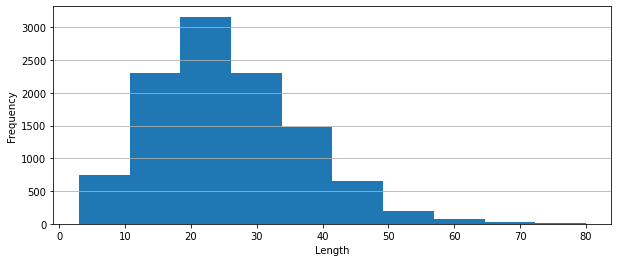

In [ ]:
length = []
for row in X_train:
  length.append(len(row.split()))
for row in X_test:
  length.append(len(row.split()))

mean = sum(length)/len(length)
print(f'''Mean = {mean}
Max = {max(length)}
Min = {min(length)}''')

plt.figure(figsize=(10, 4))
plt.hist(length)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

In [ ]:
def construct_discrete_distributions_per_tag(tagged_tokens):
    tag_probs = dict()
    vocab = dict()
    vocab['UNK'] = 1
    for token, tag in tagged_tokens:
        if token not in vocab:
            vocab[token] = 1
        else:
            vocab[token] += 1

        if tag not in tag_probs:
            tag_probs[tag] = dict()
            tag_probs[tag]['count_tag'] = dict()
            tag_probs[tag]['occurence'] = 1
        else:
            tag_probs[tag]['occurence'] += 1
            
        if token not in tag_probs[tag]['count_tag']:
            tag_probs[tag]['count_tag'][token] = 1
        else:
            tag_probs[tag]['count_tag'][token] += 1
            
    for tag in tag_probs:
        tag_probs[tag]['probs'] = dict()
        for token in vocab:
            if token in tag_probs[tag]['count_tag']:
                tag_probs[tag]['probs'][token] = float(tag_probs[tag]['count_tag'][token] + 1) / float(tag_probs[tag]['occurence'] + len(vocab))
            else:
                tag_probs[tag]['probs'][token] = 1.0 / float(len(vocab))

    return tag_probs

def construct_transition_probabilities_per_tag(tagged_tokens):
    transition_probs = dict()
    all_tags = dict()
    for i in range(len(tagged_tokens)):
        current_tag = tagged_tokens[i][1]
        if current_tag not in all_tags:
            all_tags[current_tag] = 1
        else:
            all_tags[current_tag] += 1

        if current_tag not in transition_probs:
            transition_probs[current_tag] = dict()
            transition_probs[current_tag]['occurence'] = 0
            transition_probs[current_tag]['count_transition'] = dict()
        
        # evaluate previous tag
        if i > 0:
            previous_tag = tagged_tokens[i-1][1]
            pt = tagged_tokens[i-1][0]
            transition_probs[previous_tag]['occurence'] += 1
            
            # special case for <start> tag
            if pt == '.':
                if '<start>' not in transition_probs:
                    transition_probs['<start>'] = dict()
                    transition_probs['<start>']['occurence'] = 0
                    transition_probs['<start>']['count_transition'] = dict()
                if current_tag not in transition_probs['<start>']['count_transition']:
                    transition_probs['<start>']['count_transition'][current_tag] = 0
                    
                transition_probs['<start>']['count_transition'][current_tag] += 1
                transition_probs['<start>']['occurence'] += 1       
            
            #init
            if current_tag not in transition_probs[previous_tag]['count_transition']:
                transition_probs[previous_tag]['count_transition'][current_tag] = 0
                
            transition_probs[previous_tag]['count_transition'][current_tag] += 1
    for tag in transition_probs:
        transition_probs[tag]['probs'] = dict()
        for transit_tag in all_tags:
            if transit_tag in transition_probs[tag]['count_transition']:
                transition_probs[tag]['probs'][transit_tag] = \
                    float(transition_probs[tag]['count_transition'][transit_tag]) + 1 / float(transition_probs[tag]['occurence'] + len(all_tags))
            else:
                transition_probs[tag]['probs'][transit_tag] = 1.0 / float(len(all_tags))
    
    return transition_probs

In [ ]:
def build_hmm_model(token_dist, transition_dist, model_name='hmm-tagger'):
    state_dict = dict()
    for token in token_dist:
        state_dict[token] = \
            pm.State(
                pm.DiscreteDistribution(
                    token_dist[token]['probs']
                )
                , name=token
            )
            
    model = pm.HiddenMarkovModel(model_name)
    model.add_states(list(state_dict.values()))
    
    # initialization for starting tokens
    for token, prob in transition_dist['.']['probs'].items():
        model.add_transition(state_dict[token], model.end, prob)
        
    for token, prob in transition_dist['<start>']['probs'].items():
        model.add_transition(model.start, state_dict[token], prob)
    
    transition_dist_list = list(transition_dist.items())
    for i in range(1, len(transition_dist_list)):
        ptoken, pmeta = transition_dist_list[i]
        if ptoken != '.' and ptoken != '<start>':
            for ctoken, cprob in pmeta['probs'].items():
                
                model.add_transition(
                    state_dict[ptoken],
                    state_dict[ctoken],
                    cprob
                )
    return model, state_dict

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin 

class HmmTaggerModel(BaseEstimator, ClassifierMixin):
    """
    POS Tagger with Hmm Model
    """
    def __init__(self):
        self._inner_model = None
        self._tag_dist = None
        self._transition_dist = None
        self._state_dict = None
    
    def fit(self, X, y=None):
        """
        expecting X as list of tokens, while y is list of POS tag
        """
        combined = list(zip(X, y))
        self._tag_dist = construct_discrete_distributions_per_tag(combined)
        self._transition_dist = construct_transition_probabilities_per_tag(combined)

        self._inner_model, _ = build_hmm_model(self._tag_dist, self._transition_dist)
        self._inner_model.bake()
    
    def predict(self, X):
        """
        expecting X as list of tokens
        """
        return [state.name for i, state in self._inner_model.viterbi(X)[1]][1:-1]

In [ ]:
model = HmmTaggerModel()
model.fit(hmm_X_train, hmm_y_train)

In [ ]:
def accuracy(ypred, ytrue):
    total = len(ytrue)
    correct = 0
    for pred, true in zip(ypred, ytrue):
        if pred == true:
            correct += 1
    print(correct, total)
    return float(correct) / float(total)

In [ ]:
st_idx = [0]
end_idx = [-1]

list_acc = list()
for st, end in zip(st_idx, end_idx):
    actual_words = hmm_X_test[st:end]
    actual = hmm_y_test[st:end]
    predicted = model.predict(actual_words)
    print('actual words: {}'.format(' '.join(actual_words)))
    print('actual tags: {}'.format(' '.join(actual)))
    print('predicted tags: {}'.format(' '.join(predicted)))
    print('============================================================')
    list_acc.append(accuracy(actual, predicted))
mean_acc = np.mean(list_acc)

print('mean accuracy: {}'.format(mean_acc))

actual words: UNK international corp. 's tulsa unit said it signed a tentative agreement UNK its contract with boeing co. to provide structural parts for boeing 's 747 UNK . UNK said the agreement calls for it to supply 200 additional so-called UNK for the planes . these include , among other parts , each jetliner 's two major UNK , a pressure floor , UNK box , fixed leading UNK for the UNK and an UNK UNK UNK . under the existing contract , UNK said , it has already delivered UNK of the UNK to boeing . UNK , based in el segundo , calif. , is an aerospace , electronics , automotive and graphics concern . frank UNK iii was named to this telecommunications company 's board , filling the vacancy created by the death of william UNK last may . mr. UNK , 59 years old , served as defense secretary in the reagan administration . in january , he accepted the position of vice chairman of UNK group , a merchant banking concern . shearson lehman hutton inc . thomas e. UNK , 42 years old , was named